In [35]:
## Agentic AI (developed with langraph) to refine queries for pubmed advanced search

## TODO
1. define the graph and flow of information
2. agent ask; "pls type the names of protocols separated by names you want to use" = A2, !"pls type the names of protocols separated by names you want to use" = B, and then Agent search what user may be missing?  you can now know what the user means by the Agent. Agent strategy (synonyms of the protocol), gpt gives quick description of what the protocol does (accumulated terms or vocalbulary).  
1. define tools (functions) for creating each blocks of filters (include default parameters for fall back)
2. (DONE) define tool (function) to create final query to be used for pubmed query
3. ask user for feedback. good or bad query?
5. Good? then Run pubmed advanced query 


#### always ask user for input? I'm I done?
Check for typos of user, missing delimiters (comma separated errors)

In [38]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please enter your {var}: ")

_set_env("OPENAI_API_KEY")

In [19]:
#### get the langsmith client and list workspaces
# from langsmith import Client
# client = Client()
# workspaces = client.list_workspaces()   # Returns an iterator of workspace objects
# for ws in workspaces:
#     print(ws["id"], ws["name"])


In [39]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "Workspace-1"

In [ ]:
from langsmith import Client
client = Client()
# client

Client (API URL: https://api.smith.langchain.com)

In [ ]:
## Tools
#1. create blocks (0,A1,A2,B) for filtering
#2. create blocks (0,A1,A2,B) for summarization

In [44]:
# =============================================================================
# O: BASE FILTER ONLY
# English language, exclude unwanted publication types
# =============================================================================
O_block_default = (
    '("english"[Language] '
    'NOT "meta-analysis"[Publication Type] '
    'NOT "review"[Publication Type] '
    'NOT "retracted publication"[Publication Type] '
    'NOT "retraction of publication"[Publication Type] '
    'NOT "published erratum"[Publication Type] '
    'NOT "controlled clinical trial"[Publication Type] '
    'NOT "clinical study"[Publication Type] '
    'NOT "clinical trial"[Publication Type] '
    'NOT "clinical trial protocol"[Publication Type] '
    'NOT "clinical trial, phase i"[Publication Type] '
    'NOT "clinical trial, phase ii"[Publication Type] '
    'NOT "clinical trial, phase iii"[Publication Type] '
    'NOT "clinical trial, phase iv"[Publication Type] '
    'NOT "clinical trial, veterinary"[Publication Type])'
)

# A1: INCLUSION CRITERIA - CONCEPTS (protein complexes, interactions)
A1_block_default = (
    '("nucleoproteins"[MeSH Terms] '
    'OR "protein interaction mapping"[MeSH Terms] '
    'OR (("nucleoprotein"[All Fields] OR "nucleoproteins"[All Fields] '
    'OR "multiprotein"[All Fields] OR "multiproteins"[All Fields] '
    'OR "proteins"[MeSH Terms] OR "protein"[All Fields] '
    'OR "proteins"[All Fields] OR "enzyme"[All Fields]) '
    'AND ("interact"[All Fields] OR "interacted"[All Fields] '
    'OR "interacting"[All Fields] OR "interaction"[All Fields] '
    'OR "interactions"[All Fields] OR "interactivity"[All Fields] '
    'OR "interacts"[All Fields])) '
    'OR "protein interaction"[All Fields] '
    'OR "protein interactions"[All Fields] '
    'OR "interacting protein"[All Fields] '
    'OR "interacting proteins"[All Fields] '
    'OR "multiprotein complexes"[MeSH Terms] '
    'OR (("nucleoprotein"[All Fields] OR "nucleoproteins"[All Fields] '
    'OR "multiprotein"[All Fields] OR "multiproteins"[All Fields] '
    'OR "proteins"[MeSH Terms] OR "protein"[All Fields] '
    'OR "proteins"[All Fields] OR "enzyme"[All Fields]) '
    'AND ("complex"[All Fields] OR "complexes"[All Fields] '
    'OR "heteromer"[All Fields] OR "heteromers"[All Fields] '
    'OR "homomer"[All Fields] OR "homomers"[All Fields] '
    'OR "heteromeric"[All Fields] OR "homomeric"[All Fields] '
    'OR "subunit"[All Fields] OR "subunits"[All Fields])) '
    'OR "protein complex"[All Fields] '
    'OR "protein complexes"[All Fields] '
    'OR ("protein"[All Fields] '
    'AND ("RNA"[All Fields] OR "DNA"[All Fields] '
    'OR "ribonucleic"[All Fields] OR "deoxyribonucleic"[All Fields]) '
    'AND ("interaction"[All Fields] OR "interactions"[All Fields])))'
)

# A2: INCLUSION CRITERIA - METHODS (experimental techniques we want)
A2_block_default = (
    '("Immunoprecipitation"[MeSH Terms] '
    'OR "coimmunoprecipitation"[All Fields] '
    'OR ("co"[All Fields] AND "immunoprecipitation"[All Fields]) '
    'OR ("RNA"[All Fields] AND "immunoprecipitation"[All Fields]) '
    'OR "co immunoprecipitation"[All Fields] '
    'OR "coIP"[All Fields] '
    'OR "Chromatography, Affinity"[MeSH Terms] '
    'OR "affinity purification"[All Fields] '
    'OR "affinity isolation"[All Fields] '
    'OR "affinity chromatography"[All Fields] '
    'OR ("affinity"[All Fields] AND ("purification"[All Fields] '
    'OR "isolation"[All Fields] OR "chromatography"[All Fields])) '
    'OR "pulldown"[All Fields] '
    'OR ("pull"[All Fields] AND ("down"[All Fields] OR "downs"[All Fields])) '
    'OR "crystallography, x ray"[MeSH Terms] '
    'OR "Nuclear Magnetic Resonance, Biomolecular"[MeSH Terms] '
    'OR "Cryoelectron Microscopy"[MeSH Terms] '
    'OR "Protein Array Analysis"[MeSH Terms] '
    'OR "electrophoretic mobility shift assay"[MeSH Terms] '
    'OR "Surface Plasmon Resonance"[MeSH Terms])'
)

# B: EXCLUSION CRITERIA - Methods we do NOT want
B_block_default = (
    '("Epitope Mapping"[MeSH Terms] '
    'OR "Precipitin Tests"[MeSH Terms] '
    'OR "Two-Hybrid System Techniques"[MeSH Terms] '
    'OR "blotting, far western"[MeSH Terms] '
    'OR "Radioimmunoprecipitation Assay"[MeSH Terms] '
    'OR "Autoantibodies"[MeSH Terms] '
    'OR "Chromatin Immunoprecipitation"[MeSH Terms] '
    'OR "Cross-Linking Reagents"[MeSH Terms] '
    'OR "Formaldehyde"[MeSH Terms] '
    'OR "Microscopy"[MeSH Terms] '
    'OR ("crosslink"[All Fields] AND "reagent"[All Fields]) '
    'OR "Formaldehyde"[All Fields] '
    'OR "DNA Footprinting"[MeSH Terms] '
    'OR "Nuclease Protection Assays"[MeSH Terms] '
    'OR "Blotting, Southwestern"[MeSH Terms] '
    'OR "Fluorescence Resonance Energy Transfer"[MeSH Terms] '
    'OR "PAR CLIP"[All Fields] '
    'OR "AlphaFold"[All Fields])'
)

# =============================================================================
# Final Query Logic: (O AND (A1 OR A2)) NOT (A1 AND B NOT A2)
#
# Meaning: All research papers on protein complexes (O AND (A1 OR A2)),
# excluding those that contain only methodologies we are not interested in
# (papers in A1 AND B but NOT in A2)
# =============================================================================

full_query = f"(({O_block_default}) AND (({A1_block_default}) OR ({A2_block_default}))) NOT (({A1_block_default}) AND ({B_block_default}) NOT ({A2_block_default}))"
print("=" * 80)
print("EXAMPLE FULL PUBMED QUERY")
print("=" * 80)
print(full_query)

def build_full_pubmed_query(O_block: str, A1_block: str, A2_block: str, B_block: str) -> str:
    """
    Build the full query combining O_block with other filters.

    Parameters
    ----------
    O_block : str
        Base filter block
    A1_block : str
        Inclusion criteria block 1
    A2_block : str
        Inclusion criteria block 2
    B_block : str
        Exclusion criteria block

    Returns
    -------
    str
        Complete PubMed query
    """
    return f"(({O_block}) AND (({A1_block}) OR ({A2_block}))) NOT (({A1_block}) AND ({B_block}) NOT ({A2_block}))"


EXAMPLE FULL PUBMED QUERY
((("english"[Language] NOT "meta-analysis"[Publication Type] NOT "review"[Publication Type] NOT "retracted publication"[Publication Type] NOT "retraction of publication"[Publication Type] NOT "published erratum"[Publication Type] NOT "controlled clinical trial"[Publication Type] NOT "clinical study"[Publication Type] NOT "clinical trial"[Publication Type] NOT "clinical trial protocol"[Publication Type] NOT "clinical trial, phase i"[Publication Type] NOT "clinical trial, phase ii"[Publication Type] NOT "clinical trial, phase iii"[Publication Type] NOT "clinical trial, phase iv"[Publication Type] NOT "clinical trial, veterinary"[Publication Type])) AND ((("nucleoproteins"[MeSH Terms] OR "protein interaction mapping"[MeSH Terms] OR (("nucleoprotein"[All Fields] OR "nucleoproteins"[All Fields] OR "multiprotein"[All Fields] OR "multiproteins"[All Fields] OR "proteins"[MeSH Terms] OR "protein"[All Fields] OR "proteins"[All Fields] OR "enzyme"[All Fields]) AND ("inte

## define functions for creating O_block, A1_block, A2_block, B_block

#### IDEA
_START -> AI: Howdy, Give me brief description of what you want to study? -> AI: Give me examples of protocols to include (comma separated list) -> Give me examples of protocols to exclude

In [45]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

In [46]:
## TODO 1: LangGraph Implementation
# Insert code for langraph here (Ques and Answers with the user)

from typing import TypedDict, Annotated, Literal
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
import operator

# =============================================================================
# State Definition
# =============================================================================

class GraphState(TypedDict):
    """
    State for the PubMed query builder graph.
    
    Attributes
    ----------
    messages : list
        Conversation history
    study_description : str
        What the user wants to study
    protocols_include : list
        Protocols/methods to include (A2 block)
    protocols_exclude : list
        Protocols/methods to exclude (B block)
    current_step : str
        Current step in the conversation flow
    query_blocks : dict
        Generated query blocks (O, A1, A2, B)
    """
    messages: Annotated[list, operator.add]
    study_description: str
    protocols_include: list
    protocols_exclude: list
    current_step: str
    query_blocks: dict


# =============================================================================
# Node Functions
# =============================================================================

def greet_and_ask_study(state: GraphState) -> GraphState:
    """
    Initial greeting and ask what user wants to study.
    """
    greeting = (
        "Howdy! I'm here to help you build a PubMed advanced search query "
        "for protein-protein interactions.\n\n"
        "Give me a brief description of what you want to study:"
    )
    
    state["messages"].append(AIMessage(content=greeting))
    state["current_step"] = "awaiting_study_description"
    
    return state


def process_study_description(state: GraphState) -> GraphState:
    """
    Process the study description and ask for protocols to include.
    """
    # Get the last human message as the study description
    last_human_msg = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)][-1]
    state["study_description"] = last_human_msg.content
    
    # Ask for protocols to include
    protocols_question = (
        f"Great! You want to study: {state['study_description']}\n\n"
        "Now, give me examples of experimental protocols/methods to INCLUDE "
        "(comma-separated list):\n"
        "Examples: co-IP, mass spectrometry, cryo-EM, affinity purification"
    )
    
    state["messages"].append(AIMessage(content=protocols_question))
    state["current_step"] = "awaiting_protocols_include"
    
    return state


def process_protocols_include(state: GraphState) -> GraphState:
    """
    Process protocols to include and ask for protocols to exclude.
    """
    # Get the last human message and parse protocols
    last_human_msg = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)][-1]
    protocols_raw = last_human_msg.content
    
    # Parse comma-separated list
    state["protocols_include"] = [p.strip() for p in protocols_raw.split(",") if p.strip()]
    
    # Ask for protocols to exclude
    exclusion_question = (
        f"Got it! Including: {', '.join(state['protocols_include'])}\n\n"
        "Now, give me examples of experimental protocols/methods to EXCLUDE "
        "(comma-separated list):\n"
        "Examples: yeast two-hybrid, FRET, crosslinking, ChIP-seq"
    )
    
    state["messages"].append(AIMessage(content=exclusion_question))
    state["current_step"] = "awaiting_protocols_exclude"
    
    return state


def process_protocols_exclude(state: GraphState) -> GraphState:
    """
    Process protocols to exclude and prepare for query building.
    """
    # Get the last human message and parse protocols
    last_human_msg = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)][-1]
    protocols_raw = last_human_msg.content
    
    # Parse comma-separated list
    state["protocols_exclude"] = [p.strip() for p in protocols_raw.split(",") if p.strip()]
    
    # Move to query building
    state["current_step"] = "ready_to_build_query"
    
    return state


def build_query_blocks(state: GraphState) -> GraphState:
    """
    Build the A2 and B query blocks from user inputs using LLM.
    """
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    
    # Build A2 block (protocols to include)
    a2_prompt = f"""Convert these experimental methods into a PubMed query block using MeSH terms and field tags.

Methods to include: {', '.join(state['protocols_include'])}

Format the output as a single PubMed query string using:
- "Method Name"[MeSH Terms] for standard methods
- "method name"[All Fields] for non-standard terms
- Use OR between terms
- Wrap the entire block in parentheses

Example format:
("Immunoprecipitation"[MeSH Terms] OR "mass spectrometry"[All Fields] OR "Cryoelectron Microscopy"[MeSH Terms])

Return ONLY the query block, no explanation."""

    a2_response = llm.invoke([HumanMessage(content=a2_prompt)])
    A2_block = a2_response.content.strip()
    
    # Build B block (protocols to exclude)
    b_prompt = f"""Convert these experimental methods into a PubMed query block using MeSH terms and field tags.

Methods to exclude: {', '.join(state['protocols_exclude'])}

Format the output as a single PubMed query string using:
- "Method Name"[MeSH Terms] for standard methods
- "method name"[All Fields] for non-standard terms
- Use OR between terms
- Wrap the entire block in parentheses

Example format:
("Two-Hybrid System Techniques"[MeSH Terms] OR "FRET"[All Fields] OR "Cross-Linking Reagents"[MeSH Terms])

Return ONLY the query block, no explanation."""

    b_response = llm.invoke([HumanMessage(content=b_prompt)])
    B_block = b_response.content.strip()
    
    # Store query blocks (using default O and A1)
    state["query_blocks"] = {
        "O": O_block_default,
        "A1": A1_block_default,
        "A2": A2_block,
        "B": B_block
    }
    
    # Build final query
    final_query = build_full_pubmed_query(
        O_block=state["query_blocks"]["O"],
        A1_block=state["query_blocks"]["A1"],
        A2_block=state["query_blocks"]["A2"],
        B_block=state["query_blocks"]["B"]
    )
    
    # Show results to user
    summary = f"""
Perfect! I've built your PubMed query based on:

📚 Study Topic: {state['study_description']}
✅ Methods to Include: {', '.join(state['protocols_include'])}
❌ Methods to Exclude: {', '.join(state['protocols_exclude'])}

Query Blocks Generated:
------------------------
A2 (Include): {state['query_blocks']['A2'][:100]}...
B (Exclude): {state['query_blocks']['B'][:100]}...

Full Query:
-----------
{final_query[:500]}...

The query is ready to use in PubMed Advanced Search!
"""
    
    state["messages"].append(AIMessage(content=summary))
    state["current_step"] = "completed"
    
    return state


# =============================================================================
# Conditional Routing Function (RESERVED FOR FUTURE USE)
# =============================================================================

def route_conversation(state: GraphState) -> Literal["greet", "process_study", "process_include", "process_exclude", "build_query", END]:
    """
    Route to the appropriate node based on current step.
    
    NOTE: This function is currently NOT USED in the graph.
    It's kept for future enhancements where conditional routing might be needed.
    
    Example use cases:
    - Allow users to skip steps if they already have data
    - Add validation loops (go back if input is invalid)
    - Add branches for different query types
    
    To use this, replace fixed edges with:
        workflow.add_conditional_edges(
            "node_name",
            route_conversation,
            {
                "greet": "greet",
                "process_study": "process_study",
                # ... etc
            }
        )
    """
    current = state.get("current_step", "start")
    
    if current == "start":
        return "greet"
    elif current == "awaiting_study_description":
        return "process_study"
    elif current == "awaiting_protocols_include":
        return "process_include"
    elif current == "awaiting_protocols_exclude":
        return "process_exclude"
    elif current == "ready_to_build_query":
        return "build_query"
    else:
        return END


# =============================================================================
# Build the Graph - FIX 1: CORRECT EDGES
# =============================================================================

def create_pubmed_query_graph():
    """
    Create the LangGraph for PubMed query building conversation.
    
    Returns
    -------
    StateGraph
        Compiled graph ready to run
    """
    workflow = StateGraph(GraphState)
    
    # Add nodes
    workflow.add_node("greet", greet_and_ask_study)
    workflow.add_node("process_study", process_study_description)
    workflow.add_node("process_include", process_protocols_include)
    workflow.add_node("process_exclude", process_protocols_exclude)
    workflow.add_node("build_query", build_query_blocks)
    
    # Set entry point
    workflow.set_entry_point("greet")
    
    # ✅ FIX 1: Add edges to form sequential chain (not all to END)
    workflow.add_edge("greet", "process_study")              # greet → process_study
    workflow.add_edge("process_study", "process_include")    # process_study → process_include
    workflow.add_edge("process_include", "process_exclude")  # process_include → process_exclude
    workflow.add_edge("process_exclude", "build_query")      # process_exclude → build_query
    workflow.add_edge("build_query", END)                    # build_query → END
    
    return workflow.compile()


# =============================================================================
# FIX 3: Notebook-Friendly Test Function (Non-Interactive)
# =============================================================================

def test_query_builder(study_desc: str, include_protocols: str, exclude_protocols: str):
    """
    Non-interactive version for testing in notebooks.
    
    Parameters
    ----------
    study_desc : str
        What you want to study
    include_protocols : str
        Comma-separated protocols to include
    exclude_protocols : str
        Comma-separated protocols to exclude
        
    Returns
    -------
    dict
        Final state with query blocks
        
    Example
    -------
    >>> final_state = test_query_builder(
    ...     "BRCA1 and BRCA2 interactions",
    ...     "co-IP, mass spectrometry, cryo-EM",
    ...     "yeast two-hybrid, FRET, crosslinking"
    ... )
    """
    graph = create_pubmed_query_graph()
    
    # Initialize state with user inputs already populated
    state = {
        "messages": [],
        "study_description": study_desc,
        "protocols_include": [p.strip() for p in include_protocols.split(",") if p.strip()],
        "protocols_exclude": [p.strip() for p in exclude_protocols.split(",") if p.strip()],
        "current_step": "ready_to_build_query",  # Skip conversation, go directly to building
        "query_blocks": {}
    }
    
    # Invoke the graph - will only run build_query node
    print(f"Building PubMed query for: {study_desc}")
    print(f"Including: {include_protocols}")
    print(f"Excluding: {exclude_protocols}\n")
    
    final_state = graph.invoke(state)
    
    print("\n" + "=" * 80)
    print("QUERY BUILDING COMPLETE!")
    print("=" * 80)
    
    return final_state


# =============================================================================
# Interactive Function (Original - for CLI use)
# =============================================================================

def run_query_builder_conversation():
    """
    Run an interactive conversation to build a PubMed query.
    
    NOTE: This uses input() which may not work well in Jupyter notebooks.
    Use test_query_builder() for notebook testing instead.
    
    Returns
    -------
    dict
        Final state with query blocks
    """
    graph = create_pubmed_query_graph()
    
    # Initialize state
    state = {
        "messages": [],
        "study_description": "",
        "protocols_include": [],
        "protocols_exclude": [],
        "current_step": "start",
        "query_blocks": {}
    }
    
    # Step 1: Greet
    state["messages"].append(HumanMessage(content=""))  # Trigger greet
    state = graph.invoke(state)
    print(state["messages"][-1].content)
    
    # Step 2: Get study description
    user_study = input("\n> ")
    state["messages"].append(HumanMessage(content=user_study))
    state = graph.invoke(state)
    print("\n" + state["messages"][-1].content)
    
    # Step 3: Get protocols to include
    user_include = input("\n> ")
    state["messages"].append(HumanMessage(content=user_include))
    state = graph.invoke(state)
    print("\n" + state["messages"][-1].content)
    
    # Step 4: Get protocols to exclude
    user_exclude = input("\n> ")
    state["messages"].append(HumanMessage(content=user_exclude))
    state = graph.invoke(state)
    print("\n" + state["messages"][-1].content)
    
    return state


print("✅ LangGraph setup complete!")
print("\n📝 Usage:")
print("   • For notebooks: test_query_builder('study', 'include', 'exclude')")
print("   • For CLI: run_query_builder_conversation()")


✅ LangGraph setup complete!

📝 Usage:
   • For notebooks: test_query_builder('study', 'include', 'exclude')
   • For CLI: run_query_builder_conversation()


In [ ]:
run_query_builder_conversation()

Graph Flow (ASCII):

    START
      │
      ▼
    ┌─────────────────────┐
    │ greet_and_ask_study │ ← "Howdy! What do you want to study?"
    └──────────┬──────────┘
               │ User responds
               ▼
    ┌────────────────────────────┐
    │ process_study_description  │ ← "Give me protocols to INCLUDE"
    └──────────┬─────────────────┘
               │ User responds (comma-separated)
               ▼
    ┌──────────────────────────────┐
    │ process_protocols_include    │ ← "Give me protocols to EXCLUDE"
    └──────────┬───────────────────┘
               │ User responds (comma-separated)
               ▼
    ┌──────────────────────────────┐
    │ process_protocols_exclude    │ ← Parse user inputs
    └──────────┬───────────────────┘
               │
               ▼
    ┌──────────────────────────────┐
    │ build_query_blocks           │ ← LLM converts to MeSH terms
    │  • A2 block (include)        │
    │  • B block (exclude)         │
    │  • Build final query 

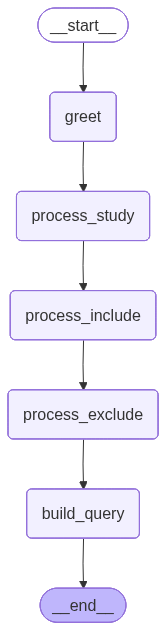

✅ Graph visualization displayed above


📊 State Flow:

State Attributes:
-----------------
• messages          → Conversation history (AI ↔ Human)
• study_description → User's research topic
• protocols_include → Methods to include (for A2 block)
• protocols_exclude → Methods to exclude (for B block)
• current_step      → Tracks position in conversation
• query_blocks      → Final O, A1, A2, B blocks

State Transitions:
------------------
1. START                      → current_step = "start"
2. After greet                → current_step = "awaiting_study_description"
3. After study input          → current_step = "awaiting_protocols_include"
4. After include input        → current_step = "awaiting_protocols_exclude"
5. After exclude input        → current_step = "ready_to_build_query"
6. After building query       → current_step = "completed"



In [47]:
# =============================================================================
# Visualize the Graph Flow
# =============================================================================

from IPython.display import Image, display

# Create the graph
graph = create_pubmed_query_graph()

# Display ASCII representation
print("Graph Flow (ASCII):")
print("=" * 80)
print("""
    START
      │
      ▼
    ┌─────────────────────┐
    │ greet_and_ask_study │ ← "Howdy! What do you want to study?"
    └──────────┬──────────┘
               │ User responds
               ▼
    ┌────────────────────────────┐
    │ process_study_description  │ ← "Give me protocols to INCLUDE"
    └──────────┬─────────────────┘
               │ User responds (comma-separated)
               ▼
    ┌──────────────────────────────┐
    │ process_protocols_include    │ ← "Give me protocols to EXCLUDE"
    └──────────┬───────────────────┘
               │ User responds (comma-separated)
               ▼
    ┌──────────────────────────────┐
    │ process_protocols_exclude    │ ← Parse user inputs
    └──────────┬───────────────────┘
               │
               ▼
    ┌──────────────────────────────┐
    │ build_query_blocks           │ ← LLM converts to MeSH terms
    │  • A2 block (include)        │
    │  • B block (exclude)         │
    │  • Build final query         │
    └──────────┬───────────────────┘
               │
               ▼
             END
""")

print("\n" + "=" * 80)

# Try to display Mermaid diagram
print("\nGraph Flow (Mermaid):")
print("=" * 80)
try:
    # Get the Mermaid diagram
    mermaid_code = graph.get_graph().draw_mermaid()
    print(mermaid_code)
    print("\n💡 Copy the Mermaid code above to https://mermaid.live/ to visualize")
except Exception as e:
    print(f"Could not generate Mermaid diagram: {e}")

# Try to display PNG if available
print("\n" + "=" * 80)
try:
    png_data = graph.get_graph().draw_mermaid_png()
    display(Image(png_data))
    print("✅ Graph visualization displayed above")
except Exception as e:
    print(f"ℹ️  PNG visualization not available: {e}")
    print("   To enable, install: pip install pygraphviz")

print("\n" + "=" * 80)
print("\n📊 State Flow:")
print("=" * 80)
print("""
State Attributes:
-----------------
• messages          → Conversation history (AI ↔ Human)
• study_description → User's research topic
• protocols_include → Methods to include (for A2 block)
• protocols_exclude → Methods to exclude (for B block)
• current_step      → Tracks position in conversation
• query_blocks      → Final O, A1, A2, B blocks

State Transitions:
------------------
1. START                      → current_step = "start"
2. After greet                → current_step = "awaiting_study_description"
3. After study input          → current_step = "awaiting_protocols_include"
4. After include input        → current_step = "awaiting_protocols_exclude"
5. After exclude input        → current_step = "ready_to_build_query"
6. After building query       → current_step = "completed"
""")

## Run the Query Builder

Use the cell below to run the interactive conversation and build your PubMed query.

In [49]:
# ✅ FIX 3: Use the notebook-friendly test function
final_state = test_query_builder(
    study_desc="BRCA1 and BRCA2 interactions in DNA repair",
    include_protocols="co-IP, mass spectrometry, cryo-EM",
    exclude_protocols="yeast two-hybrid, FRET, crosslinking"
)

# After query building completes, display the results:
print("\n" + "=" * 80)
print("GENERATED QUERY BLOCKS")
print("=" * 80)
print(f"\nA2 (Include Methods):\n{final_state['query_blocks']['A2']}\n")
print(f"\nB (Exclude Methods):\n{final_state['query_blocks']['B']}\n")

# Build and display the final query
final_query = build_full_pubmed_query(
    O_block=final_state["query_blocks"]["O"],
    A1_block=final_state["query_blocks"]["A1"],
    A2_block=final_state["query_blocks"]["A2"],
    B_block=final_state["query_blocks"]["B"]
)

print("\n" + "=" * 80)
print("COMPLETE PUBMED QUERY")
print("=" * 80)
print(final_query)
print("\n✅ Ready to use in PubMed Advanced Search!")

Building PubMed query for: BRCA1 and BRCA2 interactions in DNA repair
Including: co-IP, mass spectrometry, cryo-EM
Excluding: yeast two-hybrid, FRET, crosslinking



IndexError: list index out of range

## Graph Visualization

Run the cell below to visualize the LangGraph flow. The visualization shows:

1. **ASCII Flow Diagram** - Text-based view of the conversation flow
2. **Mermaid Diagram** - Code that can be visualized at https://mermaid.live/
3. **PNG Image** - Visual graph (if pygraphviz is installed)
4. **State Transitions** - How the state changes through the conversation

The graph implements a **sequential conversation flow** where:
- Each node asks the user for specific information
- User responses are parsed and stored in the state
- The final node uses an LLM to convert natural language protocols into proper PubMed MeSH syntax

## LangGraph Architecture Overview

### Graph Structure
```
┌─────────────────────────────────────────────────────────────────┐
│                         LANGGRAPH FLOW                          │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  Node 1: greet_and_ask_study                                   │
│  ┌─────────────────────────────────────────────────────────┐   │
│  │ Output: "Howdy! What do you want to study?"            │   │
│  │ State: current_step = "awaiting_study_description"     │   │
│  └─────────────────────────────────────────────────────────┘   │
│                              ↓                                  │
│                      [User Input]                               │
│                              ↓                                  │
│  Node 2: process_study_description                             │
│  ┌─────────────────────────────────────────────────────────┐   │
│  │ Captures: study_description                            │   │
│  │ Output: "Give me protocols to INCLUDE"                 │   │
│  │ State: current_step = "awaiting_protocols_include"     │   │
│  └─────────────────────────────────────────────────────────┘   │
│                              ↓                                  │
│                      [User Input: comma-separated list]         │
│                              ↓                                  │
│  Node 3: process_protocols_include                             │
│  ┌─────────────────────────────────────────────────────────┐   │
│  │ Captures: protocols_include = ["co-IP", "cryo-EM", ...] │   │
│  │ Output: "Give me protocols to EXCLUDE"                 │   │
│  │ State: current_step = "awaiting_protocols_exclude"     │   │
│  └─────────────────────────────────────────────────────────┘   │
│                              ↓                                  │
│                      [User Input: comma-separated list]         │
│                              ↓                                  │
│  Node 4: process_protocols_exclude                             │
│  ┌─────────────────────────────────────────────────────────┐   │
│  │ Captures: protocols_exclude = ["Y2H", "FRET", ...]     │   │
│  │ State: current_step = "ready_to_build_query"           │   │
│  └─────────────────────────────────────────────────────────┘   │
│                              ↓                                  │
│  Node 5: build_query_blocks                                    │
│  ┌─────────────────────────────────────────────────────────┐   │
│  │ LLM Call 1: Convert protocols_include → A2_block       │   │
│  │   "co-IP" → "Immunoprecipitation"[MeSH Terms]          │   │
│  │                                                         │   │
│  │ LLM Call 2: Convert protocols_exclude → B_block        │   │
│  │   "Y2H" → "Two-Hybrid System Techniques"[MeSH Terms]   │   │
│  │                                                         │   │
│  │ Output: Complete PubMed query                          │   │
│  │ State: current_step = "completed"                      │   │
│  └─────────────────────────────────────────────────────────┘   │
│                              ↓                                  │
│                            END                                  │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

### State Management

The `GraphState` persists across all nodes:

| Attribute | Type | Purpose |
|-----------|------|---------|
| `messages` | List[AIMessage \| HumanMessage] | Full conversation history |
| `study_description` | str | Research topic from user |
| `protocols_include` | List[str] | Methods to include (raw user input) |
| `protocols_exclude` | List[str] | Methods to exclude (raw user input) |
| `current_step` | str | Tracks conversation position |
| `query_blocks` | Dict[str, str] | Final O, A1, A2, B query blocks |

### LLM Integration Points

The graph uses OpenAI's GPT-4o-mini at **one node**:

**Node 5: `build_query_blocks()`**
- Converts natural language protocol names → PubMed MeSH syntax
- Makes 2 LLM calls:
  1. Build A2 block (inclusion methods)
  2. Build B block (exclusion methods)
- Uses zero-temperature for deterministic output

In [30]:
run_query_builder_conversation()

Howdy! I'm here to help you build a PubMed advanced search query for protein-protein interactions.

Give me a brief description of what you want to study:

Howdy! I'm here to help you build a PubMed advanced search query for protein-protein interactions.

Give me a brief description of what you want to study:

Howdy! I'm here to help you build a PubMed advanced search query for protein-protein interactions.

Give me a brief description of what you want to study:

Howdy! I'm here to help you build a PubMed advanced search query for protein-protein interactions.

Give me a brief description of what you want to study:


{'messages': [AIMessage(content="Howdy! I'm here to help you build a PubMed advanced search query for protein-protein interactions.\n\nGive me a brief description of what you want to study:", additional_kwargs={}, response_metadata={}),
  AIMessage(content="Howdy! I'm here to help you build a PubMed advanced search query for protein-protein interactions.\n\nGive me a brief description of what you want to study:", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='BRCA1 and BRCA2 interaction in sodium choloride', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Howdy! I'm here to help you build a PubMed advanced search query for protein-protein interactions.\n\nGive me a brief description of what you want to study:", additional_kwargs={}, response_metadata={}),
  AIMessage(content="Howdy! I'm here to help you build a PubMed advanced search query for protein-protein interactions.\n\nGive me a brief description of what you want to study:", additional_kwa